In [1]:
from math import sqrt

import numpy as np
import seaborn as sns

sns.set_palette("muted")
sns.set_style("whitegrid")

In [2]:
def generate_rnorms(N, Ws, params_list):
    rnorms = [
        np.random.normal(params[0], params[1], round(N * w))
        for params, w in zip(params_list, Ws)
    ]
    mix = np.concatenate(rnorms)
    mix_strs = [
        f"{w}×N({params[0]}, {params[1]})" for params, w in zip(params_list, Ws)
    ]
    print(" + ".join(mix_strs))
    print(f"Population mean: {np.mean(mix)}")
    print(f"Population variance: {np.var(mix)}")
    _ = sns.kdeplot(mix, bw=0.5)
    return rnorms

In [3]:
def print_modelling_and_estimation_results(choice, iters, n, rnorms, Ws, params_list):
    print(f"Choice: {choice}")
    if choice.startswith("stratify"):
        strat_sample_sizes = get_strat_sample_sizes(
            n, Ws, params_list, strategy=choice.rsplit("_", 1)[1]
        )
        n = strat_sample_sizes
        print(f"Strat samples sizes: {n}")

    print("Modelling results")
    modelling_stats = model_point_estimates(choice, iters, n, rnorms)
    print_stats(modelling_stats)

    if choice.startswith("stratify"):
        print("Estimation results")
        estimation_stats = estimate_point_estimates(rnorms, strat_sample_sizes, Ws)
        print_stats(estimation_stats)


def print_stats(stats):
    print(f"\tMean mean: {stats[0]}")
    print(f"\tMean variance: {stats[1]}")
    print(f"\tVariance mean: {stats[2]}")
    print(f"\tVariance variance: {stats[3]}")

In [4]:
def get_strat_sample_sizes(n, Ws, params_list, strategy):
    if strategy == "prop":
        nks = [int(n * w) for w in Ws]
    elif strategy == "optimal":
        np_Ws = np.array(Ws)
        np_sigmas = np.array([sqrt(sigma_square) for _, sigma_square in params_list])
        props = np.divide(np.multiply(np_Ws, np_sigmas), np.dot(np_Ws, np_sigmas))
        nks = [int(round(n * prop)) for prop in props]
    return nks

In [5]:
def model_point_estimates(choice, iters, n, rnorms):
    """Models point estimates by repeated sampling.
    
    If `choice` is stratification based `n` is expected to be list of strat sample sizes. 
    """
    means = []
    variances = []
    for i in range(iters):
        if choice == "simple":
            mix = np.concatenate(rnorms)
            sample = np.random.choice(mix, n)
            means.append(np.mean(sample))
            variances.append(np.var(sample))
        elif choice.startswith("stratify"):
            strat_samples = [
                np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, n)
            ]
            strat_mix = np.concatenate(strat_samples)
            means.append(np.mean(strat_mix))
            variances.append(np.var(strat_mix))
    return np.mean(means), np.var(means), np.mean(variances), np.var(variances)

In [6]:
def estimate_point_estimates(rnorms, strat_sample_sizes, Ws):
    strat_samples = [
        np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, strat_sample_sizes)
    ]
    strat_means = np.array([np.mean(sample) for sample in strat_samples])
    strat_vars = np.array([np.var(sample) for sample in strat_samples])
    w = np.array(Ws)
    strats_number = len(strat_sample_sizes)

    mean_mean = np.dot(w, strat_means)
    mean_var = np.dot(np.square(w), strat_vars)
    w_dot_mean_minus_mean = np.subtract(np.dot(w, strat_means), strat_means)
    var_mean = np.add(
        np.dot(w, strat_vars), np.dot(w, np.square(w_dot_mean_minus_mean))
    )
    var_var = np.add(
        np.dot(w, strat_vars), np.var(np.dot(w, np.square(w_dot_mean_minus_mean)))
    )

    return mean_mean, mean_var, var_mean, var_var

In [7]:
_iters = 1000
_N = 500
_n = 100
_Ws = [0.3, 0.5, 0.2]

### Same means and vars

0.3×N(3, 1) + 0.5×N(3, 1) + 0.2×N(3, 1)
Population mean: 2.994043866310283
Population variance: 1.025325890686447


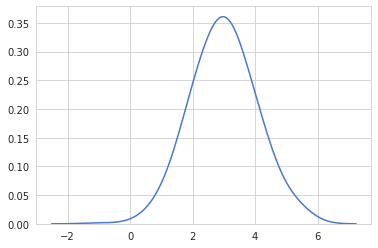

In [8]:
_params_list = [(3, 1), (3, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [9]:
print_modelling_and_estimation_results("simple", _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 2.9974624414958297
	Mean variance: 0.01016801895191842
	Variance mean: 1.00708380944417
	Variance variance: 0.020628168734660356


##### Stratified proportionally

In [10]:
print_modelling_and_estimation_results(
    "stratify_prop", _iters, _n, _rnorms, _Ws, _params_list
)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 2.9945595791693553
	Mean variance: 0.010358111815040807
	Variance mean: 1.0162501558159196
	Variance variance: 0.024508727977139717
Estimation results
	Mean mean: 2.9837305780341485
	Mean variance: 0.3311772337097507
	Variance mean: 0.9578573520163899
	Variance variance: 0.8776545474637677


##### Stratified optimally

In [11]:
print_modelling_and_estimation_results(
    "stratify_optimal", _iters, _n, _rnorms, _Ws, _params_list
)

Choice: stratify_optimal
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 2.990245972687938
	Mean variance: 0.00967018391461285
	Variance mean: 1.0094804739610164
	Variance variance: 0.022656129220833484
Estimation results
	Mean mean: 2.8176672163888847
	Mean variance: 0.32690274400375074
	Variance mean: 0.9444848622469834
	Variance variance: 0.9240903088668997


### Different means same vars

0.3×N(0, 1) + 0.5×N(10, 1) + 0.2×N(3, 1)
Population mean: 5.636435385661092
Population variance: 21.688708638894052


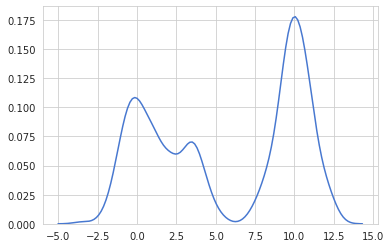

In [12]:
_params_list = [(0, 1), (10, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [13]:
print_modelling_and_estimation_results("simple", _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.638848441398578
	Mean variance: 0.2083034067422292
	Variance mean: 21.424961624505244
	Variance variance: 1.7191514272888084


##### Stratified proportionally

In [14]:
print_modelling_and_estimation_results(
    "stratify_prop", _iters, _n, _rnorms, _Ws, _params_list
)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.638283429042947
	Mean variance: 0.010467296174651341
	Variance mean: 21.65126799578952
	Variance variance: 0.8744064358367152
Estimation results
	Mean mean: 5.558255561796253
	Mean variance: 0.43144266647826435
	Variance mean: 21.497334534468443
	Variance variance: 1.1254423843095929


##### Stratified optimally

In [15]:
print_modelling_and_estimation_results(
    "stratify_optimal", _iters, _n, _rnorms, _Ws, _params_list
)

Choice: stratify_optimal
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.638644385760741
	Mean variance: 0.00991000078176035
	Variance mean: 21.659525678280392
	Variance variance: 0.8961177194219522
Estimation results
	Mean mean: 5.7365237421189175
	Mean variance: 0.3885773229571453
	Variance mean: 20.174524807561117
	Variance variance: 0.9884918071484071


### Different means and vars

0.3×N(0, 0.5) + 0.5×N(10, 1) + 0.2×N(3, 0.1)
Population mean: 5.635843307433342
Population variance: 21.135531676811652


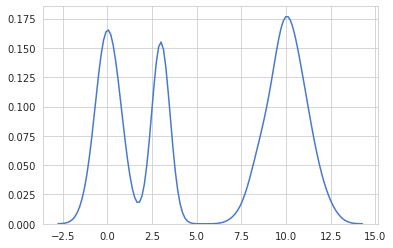

In [16]:
_params_list = [(0, 0.5), (10, 1), (3, 0.1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [17]:
print_modelling_and_estimation_results("simple", _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.644854493082079
	Mean variance: 0.21676278288560552
	Variance mean: 20.881122917493077
	Variance variance: 1.3433764932103895


##### Stratified proportionally

In [18]:
print_modelling_and_estimation_results(
    "stratify_prop", _iters, _n, _rnorms, _Ws, _params_list
)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.634827500984417
	Mean variance: 0.006345142949768257
	Variance mean: 21.15695036337062
	Variance variance: 0.5110948425135144
Estimation results
	Mean mean: 5.555748204161887
	Mean variance: 0.4046854916316898
	Variance mean: 20.96842398314984
	Variance variance: 0.8335256988192796


##### Stratified optimally

In [19]:
print_modelling_and_estimation_results(
    "stratify_optimal", _iters, _n, _rnorms, _Ws, _params_list
)

Choice: stratify_optimal
Strat samples sizes: [27, 64, 8]
Modelling results
	Mean mean: 6.750406925274314
	Mean variance: 0.008491481928519519
	Variance mean: 21.204708524875997
	Variance variance: 0.47242701783702623
Estimation results
	Mean mean: 5.516604455842995
	Mean variance: 0.2847211657716424
	Variance mean: 20.402195676092386
	Variance variance: 0.5859709683196056


### Conclusion

Based on modelling it is possible to conclude that stratified sampling indeed generally produces more representative results than simple random sampling does.